Where I attempt to solve the exercises in [section 7.6 of the d2l book](https://d2l.ai/chapter_convolutional-neural-networks/lenet.html) from scratch in pytorch (without using the d2l library).

In [15]:
#| output: false
#| code-summary: Imports
!pip3 install matplotlib

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, itertools, time

device = 'cuda'

## Context
The book section ties together convolution/pooling layer concepts seen in  previous sections and introduces the original [LeNet]() architecture:

Which is succinctly defined in PyTorch as
```
nn.Sequential(
    nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.LazyLinear(120), nn.Sigmoid(),
    nn.LazyLinear(84), nn.Sigmoid(),
    nn.LazyLinear(num_classes)
)
```
Without forgetting to use uniform Xavier initialization. Let's define the net:

In [16]:
#| code-fold: false
class LeNet(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, X):
        return self.net(X)

# Used later on to initialize the weights
def init_weights(m):
    if isinstance(m, nn.Linear) or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

And try to train it without using the d2l library.

We first get our dataset and dataloaders. We'll wrap it in a function for convinience later.

In [17]:
#| code-summary: Get data and loaders
def get_data(dataset, batch_size):
    
    data_params = {'root': 'data', 'transform': transforms.ToTensor(), 'download': True}
    train_dataset = dataset(train = True, **data_params)
    test_dataset = dataset(train = False, **data_params)
    
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

    return train_dataset, test_dataset, train_loader, test_loader

_, _, train_loader, test_loader = get_data(datasets.FashionMNIST, 128)

And functions to evaluate our models and plot losses.

In [18]:
#| code-summary: Model eval and loss ploting functions
def eval_model(model, test_loader):  
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            _, pred = torch.max(model(images), 1)
            correct += (pred == labels).float().sum().item()
    return correct / len(test_loader.dataset)

def plot_results(losses, test_acc):
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Epoch'); plt.ylabel('Cross Entropy Loss')
    plt.title(f'Test Accuracy: {test_acc:.2f}')

And finally train it using SGD with learning rate 0.1 for 15 epochs

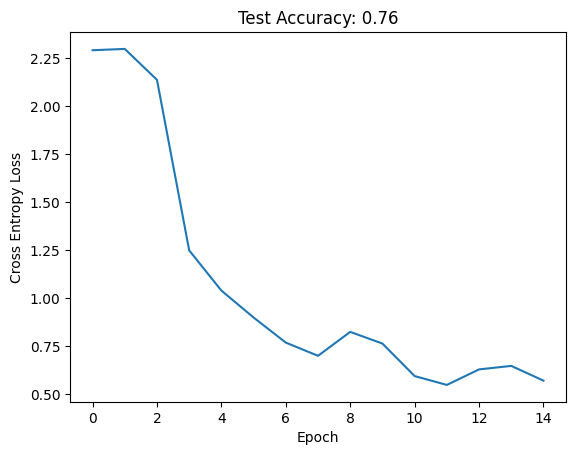

In [20]:
def train(net, train_loader, lr = 0.1, epochs = 15, verbose = True):

    # Infer input shapes, initialize weights and move to device
    _ = net(next(iter(train_loader))[0]) # Necessary before initing weights
    net.apply(init_weights)
    net.to(device)
    net.train()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr = lr)

    losses = []
    for epoch in range(epochs):
    
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            
        losses.append(loss.item())
        if verbose: print(f'Epoch: {epoch + 1} \tLoss: {loss.item():.2f}')

    return losses
        
net = LeNet(10)
losses = train(net, train_loader, verbose = False)
test_acc = eval_model(net, test_loader) 
plot_results(losses, test_acc)

And we achieve reasonable performance. Let's now attempt the section questions.

## Q1
Let’s modernize LeNet. Implement and test the following changes:

1. Replace average pooling with max-pooling.
2. Replace the softmax layer with ReLU.

We define another module and replace `nn.Sigmoid`'s for `nn.ReLu`'s and `nn.AvgPool2d`'s for `nn.MaxPool2d`'s:

In [21]:
#| code-fold: false
class ModernLeNet(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, X):
        return self.net(X)

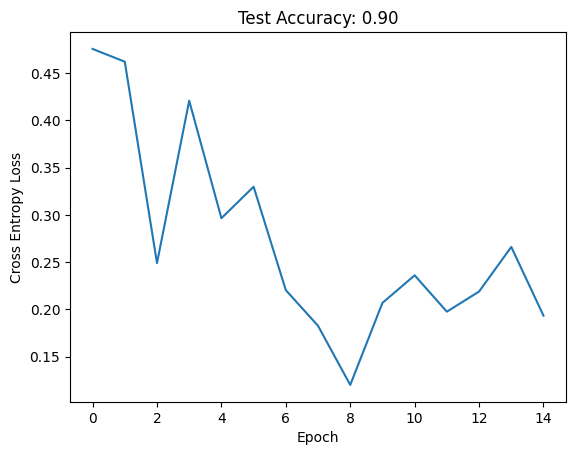

In [7]:
net = ModernLeNet(10)
losses = train(net, train_loader, verbose = False)
test_acc = eval_model(net, test_loader) 
plot_results(losses, test_acc) 

And we achieve a non-trivial improvement in performance. We even observed the loss increase slightly, indicating that our learning rate it too high (or we should decrease it on a schedule).

## Q2
Try to change the size of the LeNet style network to improve its accuracy in addition to max-pooling and ReLU.


1. Adjust the convolution window size.

Lets make everything a parameter:

In [22]:
#| code-summary: A tweakable ModernLeNet module
#| code-fold: false
class TweakableModernLeNet(nn.Module):

    def __init__(
            self, num_classes, conv_kernel = 5, out_channels = [6, 16],
            hidden_dims = [120, 84]):
        
        super().__init__()
        layers = [
            nn.Sequential(
            nn.LazyConv2d(out_c, kernel_size=conv_kernel, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) for out_c in out_channels
        ] + [nn.Flatten()] + [
            nn.Sequential(nn.LazyLinear(dim), nn.ReLU()) for dim in hidden_dims
        ] + [nn.LazyLinear(num_classes)]
    
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

Let's try adjusting the convolution window size $c_w \in \{3,..,7\}$. We'll train 5  nets per size and report the average:

Text(0, 0.5, 'Test Accuracy')

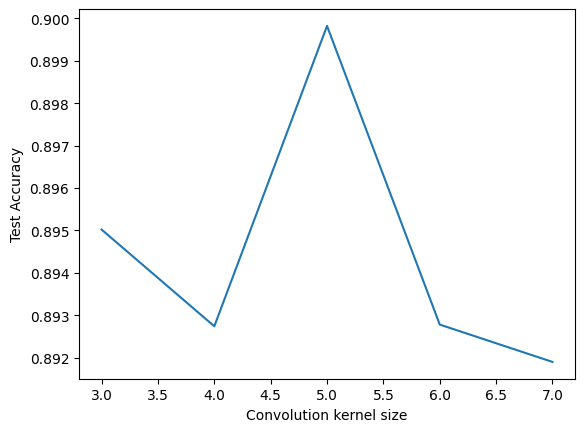

In [9]:
#| code-summary: Changing convolution window size
n_avg = 5
conv_sizes = range(3, 7 + 1)
test_accs = []
for conv_size in conv_sizes:
    avg = 0
    for _ in range(n_avg):
        net = TweakableModernLeNet(10, conv_kernel = conv_size)
        train(net, train_loader, verbose = False)
        avg += eval_model(net, test_loader)
    test_accs.append(avg / n_avg)

plt.plot(conv_sizes, test_accs)
plt.xlabel('Convolution kernel size'); plt.ylabel('Test Accuracy')

Looking at the y-axis, it seems the kernel size has only a small effect on performance in this case, and that 5 is a reasonable choice.

2. Adjust the number of output channels.

We can try halving, doubling and tripling the original [6, 16] output channels:

In [10]:
#| code-summary: Changing output channel sizes
n_avg = 3
out_channels = [[3, 8], [6, 16], [12, 22], [24, 44]]
df = []
for out_c in out_channels:
    avg = 0
    for _ in range(n_avg):
        net = TweakableModernLeNet(10, out_channels = out_c)
        train(net, train_loader, verbose = False)
        avg += eval_model(net, test_loader)
    df.append({'Output channels': out_c, 'Test Accuracy': avg / n_avg})

df = pd.DataFrame(df)
df

,Output channels,Test Accuracy
0,"[3, 8]",0.885500
1,"[6, 16]",0.894867
2,"[12, 22]",0.901233
3,"[24, 44]",0.908233


Again, the gains seem marginal and increase compute so the original seems reasonable.

3. Adjust the number of convolution layers.

Lets try adding up to 2 additional convolution layers:

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Text(0, 0.5, 'Test Accuracy')

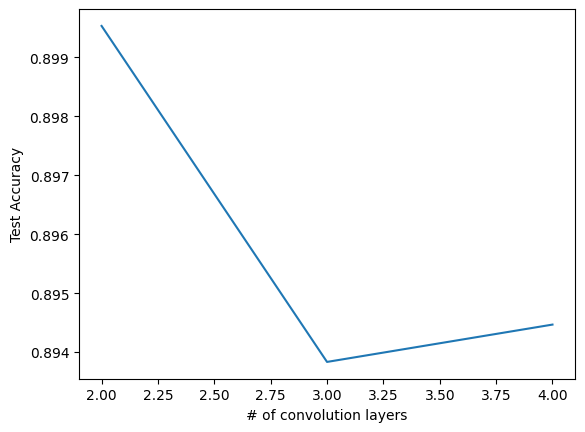

In [11]:
#| code-summary: Adding convolution layers
n_avg = 3
out_channels = [[6, 16], [6, 16, 22], [6, 16, 22, 28]]
test_accs = []
for out_c in out_channels:
    avg = 0
    for _ in range(n_avg):
        net = TweakableModernLeNet(10, out_channels = out_c)
        train(net, train_loader, verbose = False)
        avg += eval_model(net, test_loader)

    test_accs.append(avg / n_avg)

plt.plot([len(i) for i in out_channels], test_accs)
plt.xlabel('# of convolution layers'); plt.ylabel('Test Accuracy')

Same as above (see y-axis).

5. Adjust the number of fully connected layers.

Lets try 1, the original 2, 4, and 6 layers:

Text(0, 0.5, 'Test Accuracy')

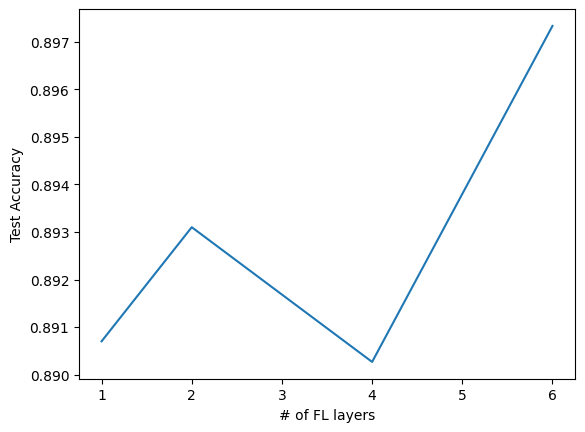

In [12]:
#| code-summary: Adding number of FL layers
n_avg = 3
hidden_dims = [[84], [120, 84], [120, 120, 84, 84], [120, 120, 120, 84, 84, 84]]
test_accs = []
for hid_dims in hidden_dims:
    avg = 0
    for _ in range(n_avg):
        net = TweakableModernLeNet(10, hidden_dims = hid_dims)
        train(net, train_loader, verbose = False)
        avg += eval_model(net, test_loader)
    test_accs.append(avg / n_avg)

plt.plot([len(i) for i in hidden_dims], test_accs)
plt.xlabel('# of FL layers'); plt.ylabel('Test Accuracy')

Same.

6. Adjust the learning rates and other training details (e.g., initialization and number of epochs).

Lets first experiment with different learning rates and try $\{0.01, 0.05, 0.1, 0.5\}$:

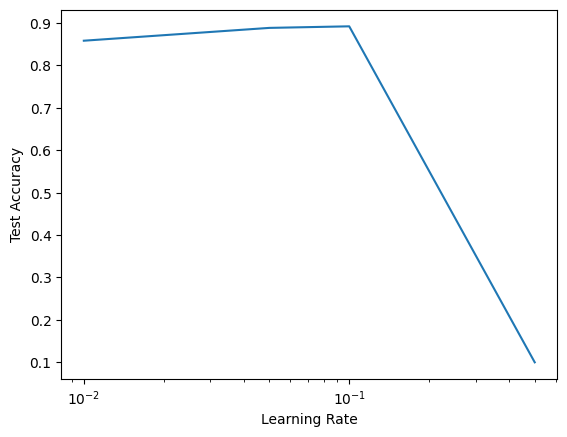

In [13]:
#| code-summary: Different learning rates
lrs = [0.01, 0.05, 0.1, 0.5]
test_accs = []
for lr in lrs:
    net = TweakableModernLeNet(10)
    train(net, train_loader, verbose = False, lr = lr)
    test_accs.append(eval_model(net, test_loader))

plt.plot(lrs, test_accs)
plt.xlabel('Learning Rate'); plt.ylabel('Test Accuracy')
plt.xscale('log')

It seams only 0.5 is too high and that our original 0.1 performs well.

## Q3
Try out the improved network on the original MNIST dataset

We can reuse code from above:

Epoch: 1 	Loss: 0.75
Epoch: 2 	Loss: 0.53
Epoch: 3 	Loss: 0.62
Epoch: 4 	Loss: 0.31
Epoch: 5 	Loss: 0.40
Epoch: 6 	Loss: 0.50
Epoch: 7 	Loss: 0.31
Epoch: 8 	Loss: 0.52
Epoch: 9 	Loss: 0.49
Epoch: 10 	Loss: 0.47
Epoch: 11 	Loss: 0.45
Epoch: 12 	Loss: 0.38
Epoch: 13 	Loss: 0.44
Epoch: 14 	Loss: 0.29
Epoch: 15 	Loss: 0.30


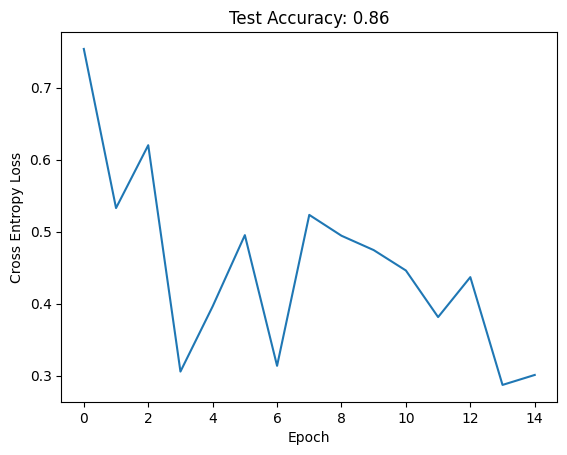

In [ ]:
#| code-summary: ModernLeNet of MNIST
_, _, train_loader_MNIST, test_loader_MNIST = get_data(datasets.MNIST, 128)
net = ModernLeNet(10)
losses = train(net, train_loader, verbose = False, lr = 0.01)
test_acc = eval_model(net, test_loader) 
plot_results(losses, test_acc)

And we get good performance.

## Q4
Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats)

Lets retrain the ModernLeNet on FashionMNIST:

In [25]:
#| code-summary: Retrain ModernLeNet on MNIST
net = ModernLeNet(10)
losses = train(net, train_loader, verbose = False)
test_acc = eval_model(net, test_loader) 
print('Test acc: ', test_acc)

Test acc:  0.8936


And now get a few sweater and coat images:

In [148]:
#| code-summary: Get images of coats and sweaters
train_dataset, _, train_loader, _ = get_data(datasets.FashionMNIST, 128)
imgs, ys = next(iter(train_loader))

coat_ix = train_dataset.classes.index('Coat')
sweater_ix = train_dataset.classes.index('Pullover')

coats_ix = [ix for ix, y in enumerate(ys) if y == coat_ix][:n]
sweaters_ix = [ix for ix, y in enumerate(ys) if y == sweater_ix][:n]

Remmember that the ReLUs are at indeces 1 and 4:

In [127]:
net

ModernLeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

We can subscript into Sequential to obtain the activations and each channel along with the input:

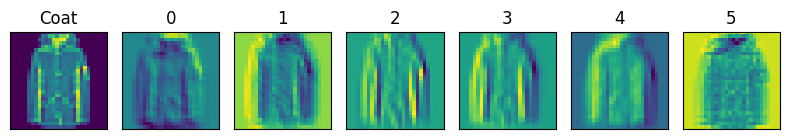

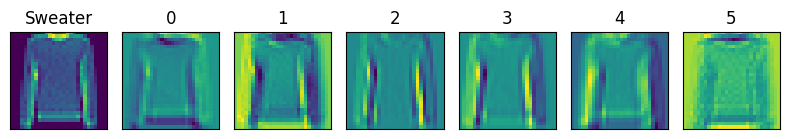

In [156]:
#| code-summary: Function to display activations
# Prepare img: add minibatch dim and move to device
def disp_acts(end_layer, images = None):

    if images is None: images = [imgs[coats_ix[0]], imgs[sweaters_ix[0]]]
    
    for name, og_img in zip(['Coat', 'Sweater'], images):
    
        img = og_img[None, :].to(device)  
        activation = net.net[:end_layer](img)
        n_channels = activation.shape[1]
        
        f, axs = plt.subplots(1, n_channels + 1, figsize = (8,5))
        axs[0].imshow(og_img.permute(1, 2, 0))
        axs[0].set_xticks([]); axs[0].set_yticks([]); axs[0].set_title(name)
        for ax, channel in zip(axs[1:], range(n_channels)):
            ax.imshow(activation.squeeze().permute(1, 2, 0)[:, :, channel].detach().to('cpu').numpy())
            ax.set_title(str(channel))
            ax.set_xticks([])
            ax.set_yticks([])
        
        f.tight_layout()
        f.show()

disp_acts(1)

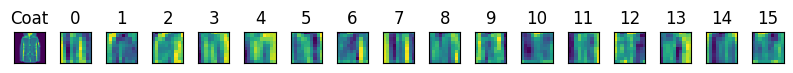

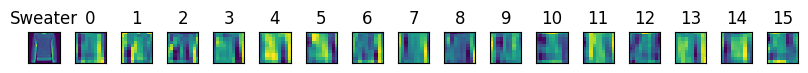

In [157]:
disp_acts(4)

And we observe that the first activation layer seems to detect lines, edges, etc. - low-level features, while the second activation layer is slightly more abstract features (although they are hard to interpret).

## Q5
What happens to the activations when you feed significantly different images into the network (e.g., cats, cars, or even random noise)?

Lets try inputing random noise:

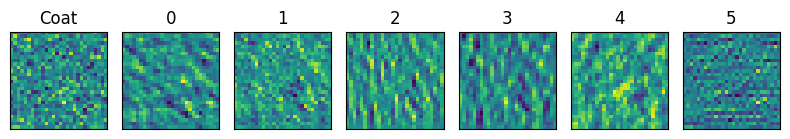

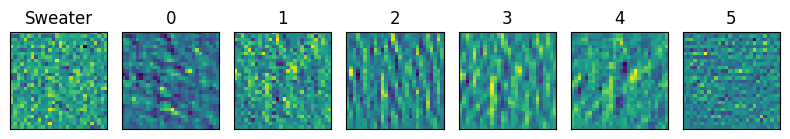

In [163]:
disp_acts(1, [torch.randn((1, 28, 28)), torch.randn((1, 28, 28))])

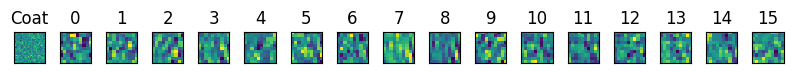

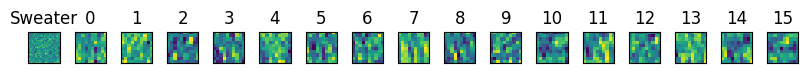

In [164]:
disp_acts(4, [torch.randn((1, 28, 28)), torch.randn((1, 28, 28))])

And the activations seem completely random, as we would expect.